# 0. Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Tabla base de incidencias de dengue

* FUENTE: https://www.dge.gob.pe/sala-situacional-dengue/#grafico01
* AUTOR: Centro Nacional de Epidemiología, Prevención y Control de Enfermedades (CDC) del Ministerio de Salud (MINSA) del Perú
* ÚLTIMA ACTUALIZACIÓN: 14 de abril, 2024
* ARCHIVOS DESCARGADOS: 'Sala situacional de enfermedades metaxénicas', derivado de la sección 'Según semana epidemiológica'. Departamentos: 'Lima' y 'Callao'.

Esta página creada por el CDC MINSA informa sobre las incidencias de dengue en función de la semana epidemiológica del 2024.
Por el enfoque de nuestro estudio, descargamos la información de los departamentos de Lima y El Callao, y pretendemos unificar sus registros.

In [3]:
# Importación y agrupación de los registros
lima = pd.read_excel("datasets/incidencias_dengue/lima2024.xlsx",sheet_name="Sheet1")
callao = pd.read_excel("datasets/incidencias_dengue/callao2024.xlsx",sheet_name="Sheet1")
base = pd.concat([lima,callao],axis=0)

# Agregación de columna suma
base['total'] = base['sin signos de alarma_total'] + base['con signos de alarma_total'] + base['grave_total']
base = base[['provincia','distrito','semana','sin signos de alarma_total','con signos de alarma_total','grave_total','total']] 
            # PENDIENTE: Discutamos sobre mantener la separación 'confirmado','sospecha' y 'total'.

# Información
print(f'Dimensiones de incidencias: {base.shape} \nLista de atributos: {list(base.columns)} ') # (1131 filas, 7 columnas)
base.describe()

Dimensiones de incidencias: (1131, 7) 
Lista de atributos: ['provincia', 'distrito', 'semana', 'sin signos de alarma_total', 'con signos de alarma_total', 'grave_total', 'total'] 


,semana,sin signos de alarma_total,con signos de alarma_total,grave_total,total
count,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000
mean,7.000000,20.144120,1.938992,0.040672,22.123784
std,3.743313,54.514052,5.512559,0.226808,59.504805
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,1.000000,0.000000,0.000000,1.000000
75%,10.000000,11.000000,1.000000,0.000000,14.000000
max,13.000000,520.000000,59.000000,4.000000,579.000000


Se pueden realizar observaciones preliminares sobre el dataset:
* Contiene la totalidad de sus datos (tiene 1131 registros y cada columna cuenta de 1131 valores).
* No se deberían sumar las semanas, debido a que solo pauta de agrupación de tiempo. Los estadísticos de esa columna no dicen nada.
* Los valores de los cuartiles hasta el 75% informan que la mayor parte del dataset cuenta con valores bastante pequeño, lo que también lo confirman las desviaciones estándar grandes y positivas. La dispersión de los datos de cada variable, tal cual está el dataset, es asimétrica positiva.

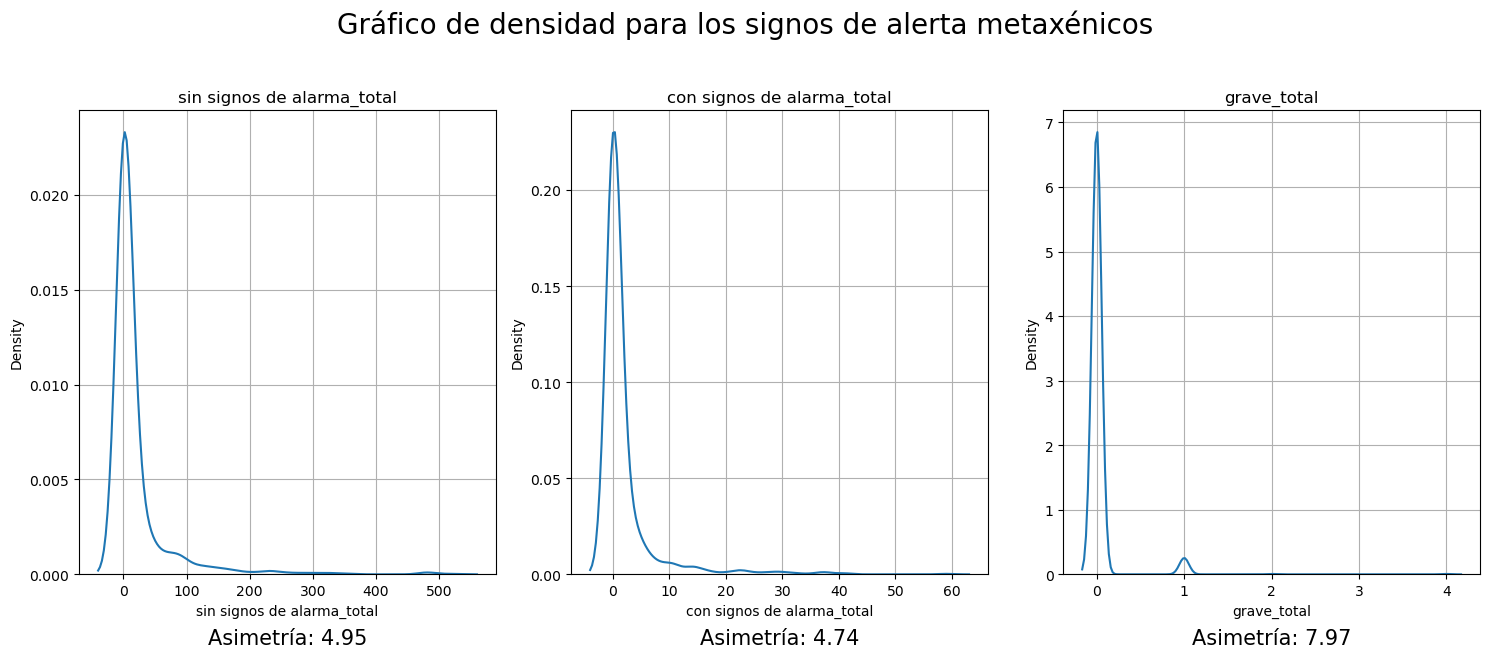

In [4]:
# Confirmación de asimetría
graph001 = base[['sin signos de alarma_total','con signos de alarma_total','grave_total']].copy()
fig, axs = plt.subplots(1,3,figsize=(15,7))

for i, column in enumerate(graph001.columns):
    sns.kdeplot(graph001[column],ax=axs[i])
    axs[i].set_title(column)
    axs[i].grid()
    skw = graph001[column].skew()    
    axs[i].text(0.5,-0.15, f'Asimetría: {skw:.2f}',ha='center',fontsize=15,transform=axs[i].transAxes)

plt.suptitle('Gráfico de densidad para los signos de alerta metaxénicos', fontsize=20)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

Procedemos a hacer agrupaciones por provincia y distritos, sumando las incidencias de dengue por semana, para ver cómo se comportan dispersos en el territorio nacional.

In [5]:
# Agrupación jerárquica para facilitar el groupby
base_jerarquica = base.set_index(['provincia','distrito'])

# Creación de bases de incidencias agrupadas en solo distritos y solo provincias.
columns = [x for x in list(base_jerarquica.columns) if x not in ['semana']]
base_provincia = base_jerarquica.groupby(level=0)[columns].sum().reset_index()
base_distrito = base_jerarquica.groupby(level=[0,1])[columns].sum().reset_index()

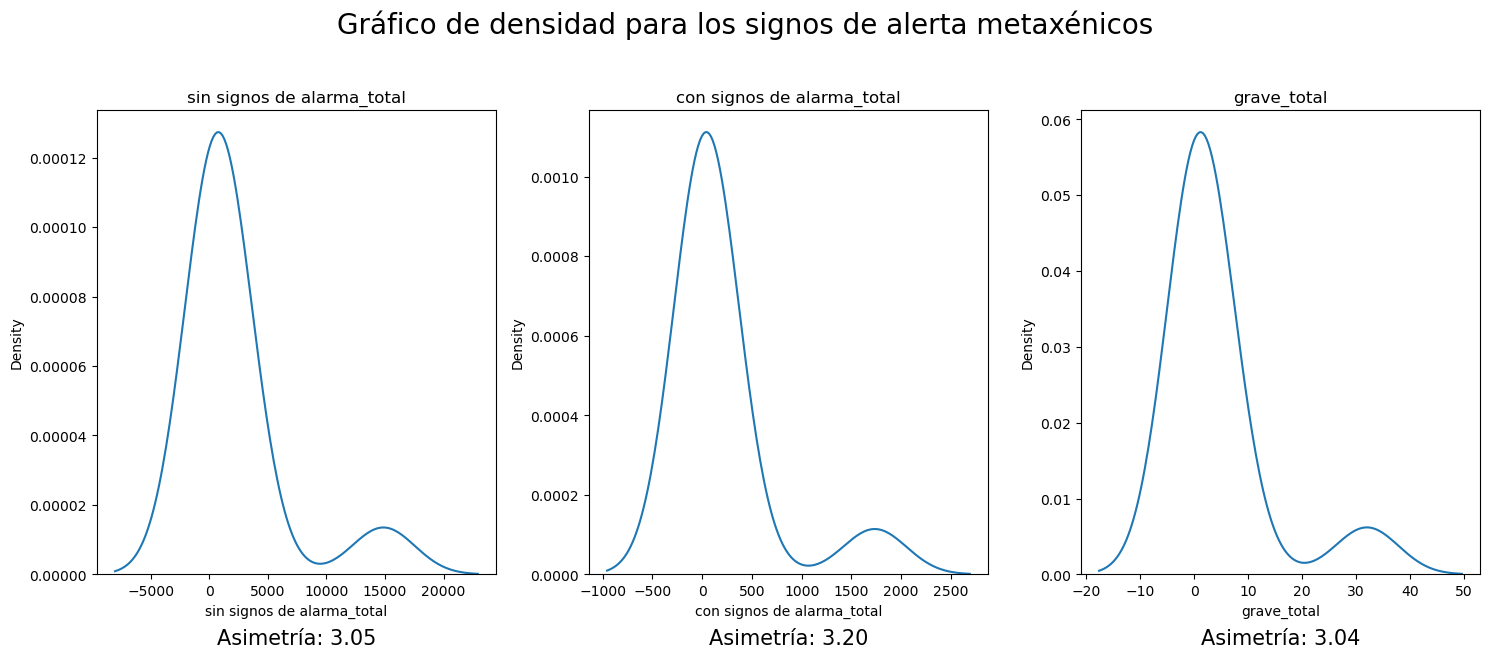

,sin signos de alarma_total,con signos de alarma_total,grave_total
count,11.000000,11.000000,11.000000
mean,2071.181818,199.363636,4.181818
std,4340.778497,514.164229,9.463807
min,0.000000,0.000000,0.000000
25%,4.000000,0.500000,0.000000
50%,259.000000,13.000000,1.000000
75%,1825.500000,67.500000,3.000000
max,14860.000000,1734.000000,32.000000


In [6]:
# Confirmación de asimetría
graph003 = base_provincia[['sin signos de alarma_total','con signos de alarma_total','grave_total']].copy()
fig, axs = plt.subplots(1,3,figsize=(15,7))

for i, column in enumerate(graph003.columns):
    sns.kdeplot(graph003[column],ax=axs[i])
    axs[i].set_title(column)
    skw = graph003[column].skew()
    axs[i].text(0.5,-0.15, f'Asimetría: {skw:.2f}',ha='center',fontsize=15,transform=axs[i].transAxes)

plt.suptitle('Gráfico de densidad para los signos de alerta metaxénicos', fontsize=20)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

graph003.describe()

# 2. Importación y preparación de archivos ShapeFile para la visualización provincial y distrital del Perú.

* FUENTE: https://www.geogpsperu.com/2018/02/limite-provincial-politico-shapefile.html
* AUTOR: GEO GPS PERÚ (recopilado del Instituto Nacional de Estadística)
* ÚLTIMA ACTUALIZACIÓN: 2023
* ARCHIVOS DESCARGADOS: 'Límites_distritales.rar' y 'Límites_provinciales.rar' (INEI, 2023)

Los archivos descargados contienen la información poligonal de los distritos y las provincias de todo el Perú, que luego será utilizada para realizar el análisis espacial pertinente en el API de OpenStreetMaps. La variable de interés para la tarea es 'geometry'; las de unión, 'provincia' y 'distrito'.

In [7]:
# Importación de valores geométricos para visualización espacial

distrital = gpd.read_file('datasets/distritos/distritos.shp')
print(f'Dimensiones de distritos.shp: {distrital.shape} \nLista de atributos: {list(distrital.columns)} ') # (1891 filas, 10 columnas)

provincial = gpd.read_file('datasets/provincias/provincias.shp')
print(f'\nDimensiones de provincias.shp: {provincial.shape} \nLista de atributos: {list(provincial.columns)} ') # (196 filas, 6 columnas)

Dimensiones de distritos.shp: (1891, 10) 
Lista de atributos: ['UBIGEO', 'CCDD', 'CCPP', 'CCDI', 'DEPARTAMEN', 'PROVINCIA', 'DISTRITO', 'OBJECTID', 'ESRI_OID', 'geometry'] 

Dimensiones de provincias.shp: (196, 6) 
Lista de atributos: ['OBJECTID', 'CCDD', 'CCPP', 'DEPARTAMEN', 'PROVINCIA', 'geometry'] 


### Registros borrados

En ambas tablas, nos quedaremos exclusivamente con los registros que corresponden a los departamentos de Lima y El Callao. Para ello, se realiza una selección de filas donde los valores de las columnas 'DEPARTAMEN' sean 'LIMA' o 'CALLAO'.

### Columnas mantenidas
* DISTRITO (solo tabla distrito): etiqueta de nombre de distrito.
* PROVINCIA: etiqueta de nombre de provincia.
* geometry: contiene la información geométrica de la zona.

Asimismo, se pasarán los nombres de las columnas a minúsculas para mantener integridad de nombre de columnas con las tablas que se trabajarán más adelante.

In [8]:
# Pasando los nombres de las columnas a minúsculas

distrital.columns = distrital.columns.str.lower()
provincial.columns = provincial.columns.str.lower()

# Selección de registros y proyección de atributos de interés
provincial = provincial.loc[((provincial['departamen']=='LIMA') | (provincial['departamen']=='CALLAO'))].reset_index()
provincial = provincial[['objectid','provincia','geometry']]

distrital = distrital.loc[((distrital['departamen']=='LIMA') | (distrital['departamen']=='CALLAO'))].reset_index()
distrital = distrital[['objectid','provincia','distrito','geometry']]

# En la tabla de incidencias de dengue, la información de El Callao no se desagrega en distritos. Por ello, ocuparemos sus polígonos de provincia para la tarea descriptiva
distrital.at[0,'geometry']  = provincial.at[0,'geometry']

print(f'Dimensiones de distrital: {distrital.shape}') # (178 filas, 4 columnas)
print(f'Dimensiones de provincial: {provincial.shape}') # (11 filas, 3 columnas)

Dimensiones de distrital: (178, 4)
Dimensiones de provincial: (11, 3)


In [9]:
# Completitud de datos en distritos
print(f'Completitud de datos en distritos (filas totales: 178): \n{distrital.count()} \n\nCompletitud de datos en provincial (filas totales: 11): \n{provincial.count()}')

Completitud de datos en distritos (filas totales: 178): 
objectid     178
provincia    178
distrito     178
geometry     178
dtype: int64 

Completitud de datos en provincial (filas totales: 11): 
objectid     11
provincia    11
geometry     11
dtype: int64


Ningún dato faltante en ambas tablas. Podemos ya trabajar con estas.

# 3. Combinación de las tablas y observación espacial

Ahora que disponemos que la información poligonal tanto para los distritos y las provincias, combinaremos ambas tablas para poder realizar una exploración espacial.

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Combinación con las tablas de información geográfica poligonal
geoprov = gpd.GeoDataFrame(base_provincia.merge(provincial,how='left',on='provincia')).set_geometry('geometry')
geodist = gpd.GeoDataFrame(base_distrito.merge(distrital,how='left',on=['provincia','distrito'])).set_geometry('geometry')


scaler = MinMaxScaler()
geoprov[['total']] = scaler.fit_transform(geoprov[['total']])
geodist[['total']] = scaler.fit_transform(geodist[['total']])

# Revisando que las tablas generadas tengan la totalidad de registros
print(f'Completitud de datos en distritos (filas totales: {geodist.shape[0]}): \n{geodist.count()} \n\nCompletitud de datos en provincial (filas totales: {geoprov.shape[0]}): \n{geoprov.count()}')

Completitud de datos en distritos (filas totales: 87): 
provincia                     87
distrito                      87
sin signos de alarma_total    87
con signos de alarma_total    87
grave_total                   87
total                         87
objectid                      87
geometry                      87
dtype: int64 

Completitud de datos en provincial (filas totales: 11): 
provincia                     11
sin signos de alarma_total    11
con signos de alarma_total    11
grave_total                   11
total                         11
objectid                      11
geometry                      11
dtype: int64


La totalidad de los datos de las dos tablas se agrupan satisfactoriamente.

### Visualizador interactivo

In [11]:
import ipywidgets
from IPython.display import HTML, display

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

outmap = ipywidgets.Output(layout={'border': '1px solid black'})
outgraph = ipywidgets.Output(layout={'border': '1px solid black'})

df = {'Provincias':geoprov,'Distritos':geodist}

w = ipywidgets.Dropdown(
    options=['Provincias','Distritos'],
    value=None,
    description='Dataset:',
    disabled=False,
)

def on_dropdown_change(change):   
    outmap.clear_output()
    outgraph.clear_output()
    gpd = df.get(w.value)
    
    with outmap:
        m = folium.Map(location=[gpd.centroid.y.mean(), gpd.centroid.x.mean()], zoom_start=7.2)
        range = (gpd['total'].quantile((0,0.001,0.05,0.3,0.5,0.8,0.9,0.98,1))).tolist()
        cp = folium.Choropleth(
              geo_data=gpd,
              name="choropleth",
              data=gpd,
              columns=['objectid','total'],
              key_on='feature.properties.objectid',
              threshold_scale=range,
              fill_color="YlGn",
              fill_opacity=0.7,
              line_opacity=0.2,
              legend_name="Incidencias de dengue (re-escalado)",
              smooth_factor=0
        ).add_to(m)

        if w.value == 'Provincias':
            fields=['provincia','sin signos de alarma_total','con signos de alarma_total','grave_total']
            aliases=['Provincia: ','Sin signos de alarma: ','Con signos de alarma: ','Grave: ']
        elif w.value == 'Distritos':
            fields=['provincia','distrito','sin signos de alarma_total','con signos de alarma_total','grave_total']
            aliases=['Provincia: ','Distrito: ','Sin signos de alarma: ','Con signos de alarma: ','Grave: ']
        
        funk = folium.features.GeoJson(
            gpd,
            style_function=style_function, 
            control=False,
            highlight_function=highlight_function, 
            tooltip=folium.features.GeoJsonTooltip(
                fields=fields,
                aliases=aliases,
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
            )
        )
        m.add_child(funk)
        m.keep_in_front(funk)
        folium.LayerControl().add_to(m)
        
        display(m)

    with outgraph:
        if w.value == 'Provincias':
            graph002 = base_provincia[['provincia','sin signos de alarma_total','con signos de alarma_total','grave_total','total']].copy().set_index('provincia')
            graph002.rename(columns={x : x[:-6] for x in graph002.columns[:-1]},inplace=True)
            
            # Gráfico
            graph002 = graph002.sort_values(by='total',ascending=True)
            
            cum = 0
            for columna in graph002.columns[:-1]:
                plt.barh(graph002.index,graph002[columna],label=columna,left=cum)
                cum += graph002[columna]

            plt.xlabel('Casos reportados')
            plt.ylabel('Provincia')
            plt.title('Incidencias de Dengue en el 2024', fontweight='bold')
            
            # Tabla (por alguna razón, la tabla entrega los valores al revés; así que por ello debemos volver a ordenar)
            graph002 = graph002.sort_values(by='total',ascending=False)
            plt.gcf().set_size_inches(12, 4)
            
            plt.table(cellText=graph002['total'].values.reshape(-1, 1),
                      rowLabels=graph002.index.tolist(),
                      colLabels=['Total'],
                      loc='right',
                      bbox=[1.3, 0, 0.2, 1], 
                      colWidths=[0.1])

            
            plt.legend()
            plt.tight_layout()
            plt.show()
        elif w.value == 'Distritos':
            graph002 = base_distrito[['provincia','distrito','sin signos de alarma_total','con signos de alarma_total','grave_total','total']].copy().set_index(['provincia','distrito'])
            graph002 = graph002.sort_values(by='total',ascending=False)
            graph002.rename(columns={x : x[:-6] for x in graph002.columns[:-1]},inplace=True)

            print("Top 10: ")
            display(graph002.head(10))
            print("Bottom 10: ")
            display(graph002.tail(10))
        

w.observe(on_dropdown_change, names='value')
display(w)

display(outmap)
display(outgraph)

Dropdown(description='Dataset:', options=('Provincias', 'Distritos'), value=None)

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [2]:
peru2000_2022 = pd.read_csv("datasets/incidencias_dengue/peru2000_2022.csv",sep=',',on_bad_lines='warn')

Skipping line 87871: expected 14 fields, saw 16
Skipping line 88799: expected 14 fields, saw 16
Skipping line 89573: expected 14 fields, saw 16

Skipping line 176478: expected 14 fields, saw 16
Skipping line 177184: expected 14 fields, saw 16
Skipping line 177191: expected 14 fields, saw 16
Skipping line 183099: expected 14 fields, saw 16

Skipping line 293518: expected 14 fields, saw 16

C:\Users\HP SUPPORT\AppData\Local\Temp\ipykernel_17844\29405928.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  peru2000_2022 = pd.read_csv("datasets/incidencias_dengue/peru2000_2022.csv",sep=',',on_bad_lines='warn')


In [71]:
peru2020_2022 = peru2000_2022.loc[((peru2000_2022['departamento']=='LIMA') | (peru2000_2022['departamento']=='CALLAO')) & ((peru2000_2022['ano'] <= 2022) & (peru2000_2022['ano'] >= 2020))]
peru2020_2022.loc[(peru2000_2022['provincia']=='CALLAO'),'distrito'] = 'CALLAO' 
peru2020_2022 = peru2020_2022[['ano','provincia','distrito','semana']]
peru2020_2022['casos'] = 1

In [80]:
# peru2020_2022.set_index(['ano','provincia','distrito','semana'],inplace=True)
inc_semanas = peru2020_2022.groupby(level=[0,1,2,3])['casos'].sum()
#inc_semanas

inc_distritos = peru2020_2022.groupby(level=[0,1,2])['casos'].sum()
#inc_distritos

inc_provincias = peru2020_2022.groupby(level=[0,1])['casos'].sum()
#inc_provincias

inc_anual = peru2020_2022.groupby(level=[0])['casos'].sum()
#inc_anual

inc_semanal = peru2020_2022.groupby(level=[0,1,3])['casos'].sum()
inc_anual

ano
2020     354
2021    1199
2022     946
Name: casos, dtype: int64

In [4]:
peru2020_2022 = peru2000_2022.loc[((peru2000_2022['departamento']=='LIMA') | (peru2000_2022['departamento']=='CALLAO')) & ((peru2000_2022['ano'] <= 2022) & (peru2000_2022['ano'] >= 2020))]
peru2020_2022['distrito'].value_counts()

distrito
LURIGANCHO                 604
COMAS                      472
SAN JUAN DE LURIGANCHO     241
PUENTE PIEDRA              201
ATE                        192
LIMA                       134
PACHACAMAC                  92
CARABAYLLO                  90
LA MOLINA                   87
VILLA MARIA DEL TRIUNFO     77
INDEPENDENCIA               68
CHACLACAYO                  50
CIENEGUILLA                 31
NUEVO IMPERIAL              24
SAN MARTIN DE PORRES        21
LOS OLIVOS                  21
IMPERIAL                    10
SAN ANTONIO                  9
MI PERU                      8
VENTANILLA                   8
RICARDO PALMA                7
SAN JUAN DE MIRAFLORES       7
SANTIAGO DE SURCO            4
RIMAC                        3
CHORRILLOS                   3
SANTA EULALIA                3
MALA                         3
VILLA EL SALVADOR            3
CALLAO                       3
LURIN                        2
LA PERLA                     2
SANTA ANITA                  2